# Documentation for the creation and usage of the heat pump library (hplib)

This documentation covers the database preperation, validation and usage for simulation. If you're only interested in using hplib for simulation purpose, you should have a look into chapter [4. How to simulate](#how-to-simulate).

1. [Definitions](#definitions)
2. [Database preperation](#database-preparation)
3. [Work with database](#work-with-database)
    1. [Load database](#load-database)
    2. [Load specific model](#load-specific-model)
    3. [Load generic model](#load-generic-model)
4. [How to simulate](#how-to-simulate)
    1. [Simulate on time step](#simulate-one-timestep)
    2. [Simulate a time series](#simulate-a-timeseries)
5. [Example heat pump](#example-heat-pump)
6. [Validation](#validation)
    1. [Air/Water | on/off](#air-water-onoff)
    2. [Brine/Water | on/off](#brine-water-onoff)
    3. [Water/Water | on/off](#water-water-onoff)
    4. [Air/Water | regulated](#air-water-regulated)
        1. [Heating](#air-water-regulated-heating)
        2. [Cooling](#air-water-regulated-cooling)
    5. [Brine/Water | regulated](#brine-water-regulated)
7. [Conclusion](#conclusion)
8. [Additional functions](#additional-functions)

In [1]:
import os
os.chdir(r'../hplib')
import hplib as hpl
import hplib_database as db
import pandas as pd
import warnings
import numpy
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
%%html
<style>
table {float:left}
</style>

## **1. Definitions** <a class="anchor" id="definitions" name="definitions"></a>

**Abbreviations**

| Abbreviation | Meaning |
| :--- | :--- |
| P_th | Thermal output power in W |
| P_el | Electical input Power in W |
| COP | Coefficient of performance |
| EER | Energy Efficiency Ratio |
| T_in | Input temperature in °C at primary side of the heat pump |
| T_out | Output temperature in °C at secondary side of the heat pump |
| T_amb | Ambient temperature in °C |
| P_th_h_ref | Thermal heating output power in W at T_in = -7 °C and T_out = 52 °C |
| P_el_h_ref | Elecrical input power (heating) in W at T_in = -7 °C and T_out = 52 °C |
| COP_ref | Coefficient of performance at T_in = -7 °C and T_out = 52 °C |
| P_th_c_ref | Thermal cooling output power in W at T_in = 35 °C and T_out = 7 °C |
| P_el_c_ref | Elecrical input power (cooling) in W at T_in = 35 °C and T_out = 7 °C |
| p1-p4 | Fit-Parameters for Fit-Function |



**Group IDs**

| Group ID | Type | Subtype |
| :--- | :--- | :--- |
| 1 | Outdoor Air / Water | Regulated | 
| 2 | Brine / Water | Regulated | 
| 3 | Water / Water | Regulated | 
| 4 | Outdoor Air / Water | On-Off | 
| 5 | Brine / Water | On-Off | 
| 6 | Water / Water | On-Off |

## **2. Database preparation** <a class="anchor" id="database-preparation" name="database-preparation"></a>

This section is only for documentation regarding the development of the final database. It's not neccesary to run this code again.

In [ ]:
# Import keymark data from https://keymark.eu/en/products/heatpumps/certified-products and save to csv files 
db.import_keymark_data(0)
# -> this creates /input/csv_%M_%Y/

In [ ]:
# Merge files in one csv
db.combine_raw_csv(foldername='csv')
# -> this creates /output/database.csv 

In [ ]:
# Many heat pump models have redundant entries because of different controller or storage configurations.
# Reduce to unique heat pump models.
db.reduce_heating_data()
# -> this creates /output/database_reduced.csv

In [ ]:
# Heating: Normalize electrical power from the keymark database to values from setpoint T_in = -7 °C and T_out = 52 °C
# Cooling: Normalize electrical power from the keymark database to values from setpoint T_outside = 35 °C and T_out = 7 °C
db.normalize_data()
# -> this creates /output/database_reduced_normalized.csv

In [ ]:
# Identify subtypes like on-off or regulated heat pumps and assign group id depending on its type and subtype
db.identify_subtypes()
# -> this creates /output/database_reduced_normalized_subtypes.csv

In [ ]:
# Calculate parameters p1-p4 for P_el_h, P_el_c, COP and EER with a least-square fit approach
# based on  K. Schwamberger: „Modellbildung und Regelung von Gebäudeheizungsanlagen 
# mit Wärmepumpen“, VDI Verlag, Düsseldorf, Fortschrittsberichte VDI Reihe 6 Nr. 263, 1991.
db.calculate_fitting_parameters()
# -> this creates hplib_database.csv
# -> this creates /output/database_reduced_normalized_subtype_parameters.csv

In [3]:
# Calculate the relative error (RE) for each set point of every heat pump
# and calculate the mean absolute percentage error (MAPE) for every heat pump
db.validation_re_mape()
# -> this creates /output/relative_error.csv
# -> this overwrites the hplib_database.csv

#TODO: 
 - check Validation 
 - check generics

**Create generic heat pump models**

In [4]:
# Calculate generic heat pump models for each group id
# for cooling: there is only a generic heat pump of type air/water | regulated available
db.add_generic()
#db.same_built_type()
# -> this overwrites the /hplib/hplib_database.csv

**Hint:** The csv files in the `output` folder are for documentation and validation purpose. The code `hplib.py` and database `hplib_database` files, which are meant to be used for simulations, are located in the `hplib` folder. 

## **3. Work with database** <a class="anchor" id="work-with-database" name="work-with-database"></a>

### **3.1 Load database**  <a class="anchor" id="load-database" name="load-database"></a>

Simply execute the command without arguments and you will get a DataFrame with the complete list of manufacturers and models. Now you are able to view, filter or sort the database.

In [5]:
database = hpl.load_database()
database

,Manufacturer,Model,Titel,Date,Type,Subtype,Group,Rated Power low T [kW],Rated Power medium T [kW],Refrigerant,...,p1_EER [-],p2_EER [-],p3_EER [-],p4_EER [-],MAPE P_th,MAPE P_el,MAPE COP,MAPE Pdc,MAPE P_el_c,MAPE EER
0,Acond a.s.,Acond Grandis-N,Acond Grandis-N,07.12.2022,Outdoor Air/Water,Regulated,1.0,4.20,4.00,R290,...,NaN,NaN,NaN,NaN,12.152181,7.407828,9.656971,NaN,NaN,NaN
1,Acond a.s.,Acond Grandis-R,Acond Grandis-R,07.12.2022,Outdoor Air/Water,Regulated,1.0,10.19,9.97,R290,...,NaN,NaN,NaN,NaN,8.351668,5.454839,10.633878,NaN,NaN,NaN
2,Acond a.s.,Acond Grandis-R,Acond Grandis-R SP,07.12.2022,Outdoor Air/Water,Regulated,1.0,10.19,9.97,R290,...,NaN,NaN,NaN,NaN,8.351668,5.454839,10.633878,NaN,NaN,NaN
3,Acond a.s.,Acond PRO-N,Acond PRO-N,17.03.2022,Outdoor Air/Water,Regulated,1.0,5.29,5.14,R290,...,NaN,NaN,NaN,NaN,7.115390,4.126136,3.479832,NaN,NaN,NaN
4,Acond a.s.,Acond PRO-R,Acond PRO-R,17.03.2022,Outdoor Air/Water,Regulated,1.0,10.38,10.17,R290,...,NaN,NaN,NaN,NaN,9.870311,5.932891,7.070495,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6336,Generic,Generic,Generic_average,NaN,Outdoor Air/Water,On-Off,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0
6337,Generic,Generic,Generic_top,NaN,Brine/Water,On-Off,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0
6338,Generic,Generic,Generic_average,NaN,Brine/Water,On-Off,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0
6339,Generic,Generic,Generic_bottom,NaN,Brine/Water,On-Off,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0


### **3.2 Load specific model**  <a class="anchor" id="load-specific-model" name="load-specific-model"></a>

To get the parameters of a specific heat pump model, use the `get_parameters()` method with a specific Model titel from the database.
You will get a DataFrame with all parameters including the mean absolute percentage errors (MAPE) for this model.

In [6]:
parameters = hpl.get_parameters('i-SHWAK V4 06')
parameters

,Manufacturer,Model,Titel,Date,Type,Subtype,Group,Rated Power low T [kW],Rated Power medium T [kW],Refrigerant,...,p1_EER [-],p2_EER [-],p3_EER [-],p4_EER [-],MAPE P_th,MAPE P_el,MAPE COP,MAPE Pdc,MAPE P_el_c,MAPE EER
54,Advantix S.p.A.,i-SHWAK V4 06,i-SHWAK V4 06,26.05.2020,Outdoor Air/Water,Regulated,1.0,5.0,4.0,R410A,...,-67.220839,0.204912,7.427597,67.043676,24.897666,22.607658,9.244852,8.701458,13.615717,8.84823


### **3.3 Load generic model**  <a class="anchor" id="load-generic-model" name="load-generic-model"></a>

To get the parameters of a generic heat pump model, use the `get_parameters()` method with the following keyword arguments of a free choosen set point

* model='Generic_average', 'Generic_top', 'Generic_bottom'
* group_id: 1,2,4,5,6
* t_in: choose primary input temperature in °C
* t_out: choose secondary output temperature in °C
* p_th: choose thermal output power in W

You will get a DataFrame with all parameters for this generic model. For every group id the parameter set is based on the average parameters of all heat pumps of its group with an MAPE of less than 25%.

In [7]:
parameters = hpl.get_parameters(model='Generic_bottom', group_id=1, t_in=-7, t_out=30, p_th=10000)
HP_low=hpl.HeatPump(parameters)
parameters = hpl.get_parameters(model='Generic_top', group_id=1, t_in=-7, t_out=30, p_th=10000)
HP_top=hpl.HeatPump(parameters)
parameters = hpl.get_parameters(model='Generic_average', group_id=1, t_in=-7, t_out=30, p_th=10000)
HP_average=hpl.HeatPump(parameters)
parameters

,Manufacturer,Model,Titel,Date,Type,Subtype,Group,Rated Power low T [kW],Rated Power medium T [kW],Refrigerant,...,p2_EER [-],p3_EER [-],p4_EER [-],MAPE P_th,MAPE P_el,MAPE COP,MAPE Pdc,MAPE P_el_c,MAPE EER,EER_ref
6330,Generic,Generic,Generic_average,NaN,Outdoor Air/Water,Regulated,1.0,NaN,NaN,NaN,...,0.260661,12.798861,-93.064848,0.0,0.0,0.0,0.0,0.0,0.0,2.255471


In [ ]:
parameters = hpl.get_parameters(model='Generic_top', group_id=1, t_in=10, t_out=40, p_th=10000)
parameters

## **4. How to simulate** <a class="anchor" id="how-to-simulate" name="how-to-simulate"></a>

With the Fit-Parameters p1-p4 for P_th, P_el and COP it is possible to calculate the results with the following methods:

1. P_th and P_el with Fit-Functions and `COP = P_th / P_el` or
2. P_th and COP with Fit-Functions and `P_el = P_th / COP` or
3. P_el and COP with Fut-Functions and `P_th = P_el * COP`

While the model by Schwarmberger [1] uses the first method, our validation showed, that the third method leads to better results. Therefore we decided to implement this in the `simulate` definition.

### **4.1 Simulate one timestep**  <a class="anchor" id="simulate-one-timestep" name="simulate-one-timestep"></a>

Please define a primary input temperature (t_in_primary), secondary input temperature (t_in_secondary),
ambient / outdoor temperature (t_amb) in °C and the parameters from the previous step. The t_in_secondary
is supposed to be heated up by 5 K which then results in output temperature.

Important:
* for air / water heat pumps t_in_primary and t_amb are supposed to be the same values.
* for brine / water or water / water heat pumps t_in_primary and t_amb are independent values.

In [10]:
# Load parameters
parameters = hpl.get_parameters(model='Generic_top', group_id=1, t_in=-7, t_out=40, p_th=10000)
# Create heat pump object with parameters
heatpump = hpl.HeatPump(parameters)
# Simulate with values
# whereas mode = 1 is for heating and mode = 2 is for cooling
results = heatpump.simulate(t_in_primary=-7, t_in_secondary=35, t_amb=-7, mode=1)
print(pd.DataFrame([results]))

   T_in  T_out  T_amb       COP  EER         P_el     P_th    m_dot
0    -7     40     -7  2.765865    0  3615.504848  10000.0  0.47619


In [11]:
# Load parameters
parameters = hpl.get_parameters(model='Generic_bottom', group_id=1, t_in=-7, t_out=40, p_th=10000)
# Create heat pump object with parameters
heatpump = hpl.HeatPump(parameters)
# Simulate with values
# whereas mode = 1 is for heating and mode = 2 is for cooling
results = heatpump.simulate(t_in_primary=-7, t_in_secondary=35, t_amb=-7, mode=1)
print(pd.DataFrame([results]))

   T_in  T_out  T_amb       COP  EER         P_el     P_th    m_dot
0    -7     40     -7  2.339143    0  4275.069314  10000.0  0.47619


### **4.2 Simulate a timeseries**  <a class="anchor" id="simulate-a-timeseries" name="simulate-a-timeseries"></a>

The simulation approach could be to do a `for loop` around the method of simulating one timestep. But it will be faster to use the previous method with arrays as inputs. For usage you are allowed to define pandas.Series or arrays as input values. It is also possible to combine single values and pandas.Series / arrays.

*The next example uses a measured timeseries for ambient / outdoor temperature and secondary 
input temperature of a real heating system to demonstrate the simulation approach. The data represents
on year and has a temporal resolution of 1 minute*

The seasonal performance factor (SPF) for one year is = 4.1


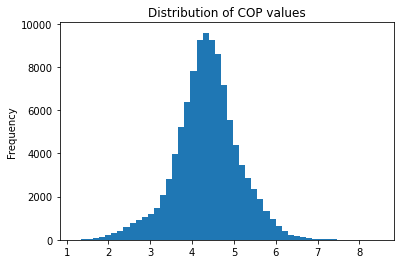

In [12]:
# Read input file with temperatures
df = pd.read_csv('../input/TestYear.csv')
df['T_amb'] = df['T_in_primary'] # air/water heat pump -> T_amb = T_in_primary
# Simulate with values
# Load parameters
parameters = hpl.get_parameters('Generic_top', group_id=1, t_in=-7, t_out=40, p_th=10000)
# Create heat pump object with parameters
heatpump = hpl.HeatPump(parameters)
# whereas mode = 1 is for heating and mode = 2 is for cooling
results = heatpump.simulate(t_in_primary=df['T_in_primary'].values, t_in_secondary=df['T_in_secondary'].values, t_amb=df['T_amb'].values, mode=1)
# Plot / Print some results
# example for distribution of COPs
results=pd.DataFrame.from_dict(results)
results['COP'].plot.hist(bins=50, title='Distribution of COP values') 
# Calclulate seasonal performance factor (SPF)
SPF = results['P_th'].mean() / results['P_el'].mean() 
print('The seasonal performance factor (SPF) for one year is = '+str(round(SPF,1)))

The seasonal performance factor (SPF) for one year is = 3.8


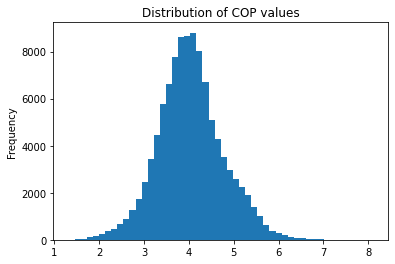

In [13]:
# Read input file with temperatures
df = pd.read_csv('../input/TestYear.csv')
df['T_amb'] = df['T_in_primary'] # air/water heat pump -> T_amb = T_in_primary
# Simulate with values
# Load parameters
parameters = hpl.get_parameters('Generic_bottom', group_id=1, t_in=-7, t_out=40, p_th=10000)
# Create heat pump object with parameters
heatpump = hpl.HeatPump(parameters)
# whereas mode = 1 is for heating and mode = 2 is for cooling
results = heatpump.simulate(t_in_primary=df['T_in_primary'].values, t_in_secondary=df['T_in_secondary'].values, t_amb=df['T_amb'].values, mode=1)
# Plot / Print some results
# example for distribution of COPs
results=pd.DataFrame.from_dict(results)
results['COP'].plot.hist(bins=50, title='Distribution of COP values') 
# Calclulate seasonal performance factor (SPF)
SPF = results['P_th'].mean() / results['P_el'].mean() 
print('The seasonal performance factor (SPF) for one year is = '+str(round(SPF,1)))

## **5. Example heat pump** <a class="anchor" id="example-heat-pump" name="example-heat-pump"></a>

To get a overview over the different operation conditions, this section plots the electrical and thermal power as well as the COP for all possible primary and secondary input temperatures
 
HEATING: **Schematic plot** of COP, P_el and P_th for an **generic air/water** heat pump: subtype = **regulated** 

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

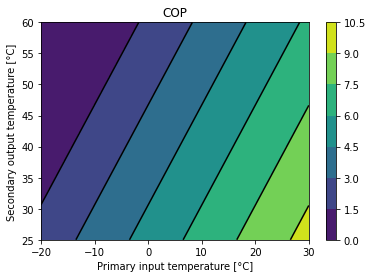

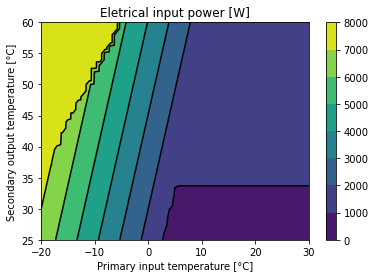

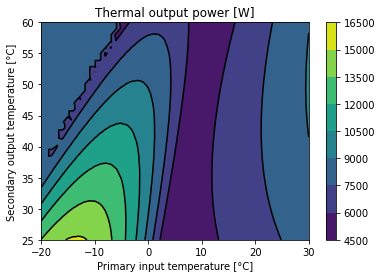

In [14]:
# Define Temperatures
T_in_primary = range(-20,31)
T_in_secondary = range(20,56)
T_in = numpy.array([])
T_out = numpy.array([])

# Load parameters of generic air/water | regulated
parameters = hpl.get_parameters('Generic_average', group_id=1, t_in=-7, t_out=45, p_th = 10000)
heatpump=hpl.HeatPump(parameters)
results=pd.DataFrame()
# Create input series
for t1 in T_in_primary:
    for t2 in T_in_secondary:
        T_in=numpy.append(T_in,t1)
        T_out=numpy.append(T_out,t2)
results=heatpump.simulate(t_in_primary=T_in, t_in_secondary=T_out, t_amb=T_in, mode=1)
results=pd.DataFrame.from_dict(results)

# Plot COP
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['COP'])
ax1.tricontour(results['T_in'], results['T_out'], results['COP'], colors='k')
fig1.colorbar(plot)
ax1.set_title('COP')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot electrical input power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_el'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_el'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Eletrical input power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot thermal output power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_th'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_th'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Thermal output power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

COOLING: **Schematic plot** of EER, P_el and P_th for an **generic air/water** heat pump: subtype = **regulated** 

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

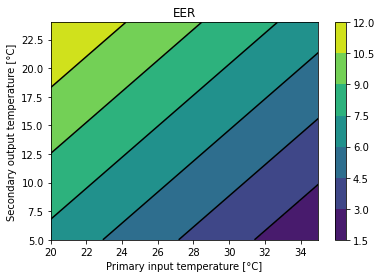

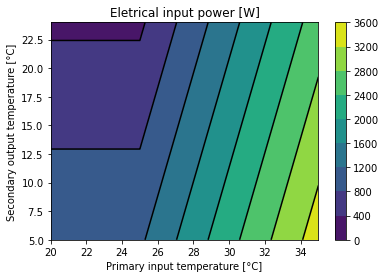

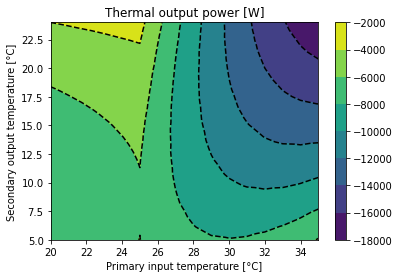

In [15]:
# Define Temperatures
T_in_primary = range(20,36)
T_in_secondary = range(10,30)
T_in = numpy.array([])
T_out = numpy.array([])

# Load parameters of generic air/water | regulated
parameters = hpl.get_parameters('Generic_average', group_id=1, t_in=-7, t_out=45, p_th = 10000)
heatpump=hpl.HeatPump(parameters)
results=pd.DataFrame()
# Create input series
for t1 in T_in_primary:
    for t2 in T_in_secondary:
        T_in=numpy.append(T_in,t1)
        T_out=numpy.append(T_out,t2)
results=heatpump.simulate(t_in_primary=T_in, t_in_secondary=T_out, t_amb=T_in, mode=2)
results=pd.DataFrame.from_dict(results)
# Plot EER
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['EER'])
ax1.tricontour(results['T_in'], results['T_out'], results['EER'], colors='k')
fig1.colorbar(plot)
ax1.set_title('EER')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot electrical input power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_el'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_el'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Eletrical input power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot thermal output power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_th'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_th'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Thermal output power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

In [16]:
df=hpl.load_database()
print(len(df[df['Group']==1]),len(df[df['Group']==2]),len(df[df['Group']==3]),len(df[df['Group']==4]),len(df[df['Group']==5]),len(df[df['Group']==6]))

5812 283 6 40 194 6


## **6. Validation** <a class="anchor" id="validation" name="validation"></a>

The following plots will give you a detailed view on the differences between simulation and measurement from heat pump keymark. Therefore, all set points for all heat pumps are loaded from the file `database_heating_average_normalized_subtypes_validation.csv`.

In [17]:
df = pd.read_csv('../output/relative_error.csv')
df.columns=['T_in [°C]', 'T_out [°C]', 'T_amb [°C]', 'COP_sim', 'EER_sim', 'P_el_sim', 'P_th_sim', 'm_dot',
       'P_th [W]', 'P_el [W]', 'COP', 'RE_P_th', 'RE_P_el', 'RE_COP',
       'titel', 'Group', 'Pdc_real', 'Pel_c_real', 'EER_real', 'RE_Pdc',
       'RE_Pel_c', 'RE_EER']
df

,T_in [°C],T_out [°C],T_amb [°C],COP_sim,EER_sim,P_el_sim,P_th_sim,m_dot,P_th [W],P_el [W],...,RE_P_el,RE_COP,titel,Group,Pdc_real,Pel_c_real,EER_real,RE_Pdc,RE_Pel_c,RE_EER
0,-7,34,-7,3.627524,0.0,1093.845996,3967.952079,0.188950,3720.0,1060.0,...,3.193019,3.348248,Acond Grandis-N,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,-7,52,-7,1.745311,0.0,1411.153689,2462.902228,0.117281,3540.0,1445.0,...,-2.342305,-28.762811,Acond Grandis-N,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,30,2,5.640453,0.0,379.229228,2139.024785,0.101858,2260.0,430.0,...,-11.807156,7.437207,Acond Grandis-N,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2,42,2,4.385645,0.0,590.767690,2590.897437,0.123376,2150.0,540.0,...,9.401424,10.192088,Acond Grandis-N,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7,27,7,6.840078,0.0,242.612140,1659.485943,0.079023,1520.0,223.0,...,8.794682,0.441673,Acond Grandis-N,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64475,2,42,2,3.825709,0.0,1574.383164,6023.131922,0.286816,4580.0,1396.0,...,12.778164,16.637471,PAVH-12V1FXC,1.0,NaN,NaN,NaN,NaN,NaN,NaN
64476,7,27,7,6.263687,0.0,602.745877,3775.411321,0.179781,4470.0,722.0,...,-16.517192,1.190415,PAVH-12V1FXC,1.0,NaN,NaN,NaN,NaN,NaN,NaN
64477,7,36,7,5.373341,0.0,700.764926,3765.449099,0.179307,4240.0,918.0,...,-23.663951,16.306088,PAVH-12V1FXC,1.0,NaN,NaN,NaN,NaN,NaN,NaN
64478,12,24,12,7.514537,0.0,570.072860,4283.833655,0.203992,5370.0,612.0,...,-6.850840,-14.315427,PAVH-12V1FXC,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### **6.1 Air/Water | on/off** <a class="anchor" id="air-water-onoff" name="air-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 5.4 % for COP
    * 2.5 % for P_el
    * 5.8 % for P_th
* The errors come from deviation mostly at low ambient / outside temperatures

RE_COP     5.413280
RE_P_el    2.547263
RE_P_th    5.916304
dtype: float64

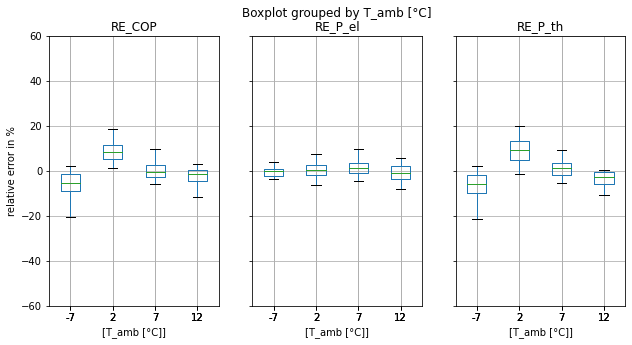

In [18]:
# Plot relative error for all heat pumps of type air/water | on-off
Group = 4
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

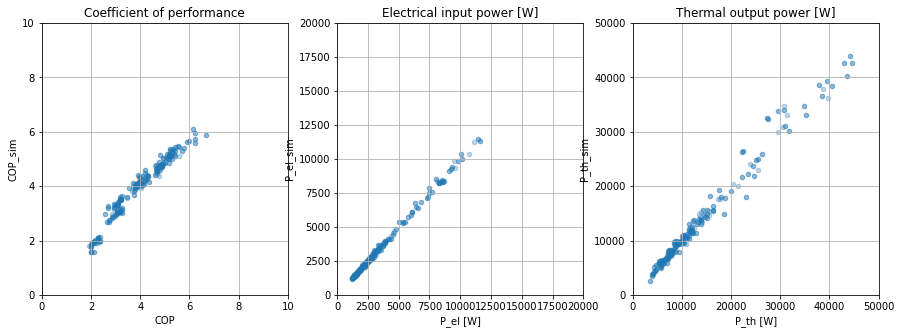

In [19]:
# Plot absolute values all heat pumps of type air/water | on-off as scatter plot
Group = 4
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.2 Brine/Water | on/off** <a class="anchor" id="brine-water-onoff" name="brine-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 3.9 % for COP
    * 1.7 % for P_el
    * 2.7 % for P_th
* **Important**: Validation data is only available at primary input temperature of 0 °C.  

RE_COP     3.243736
RE_P_el    1.420542
RE_P_th    2.544080
dtype: float64

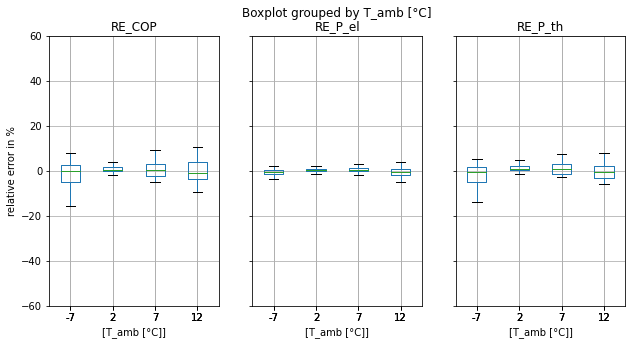

In [20]:
# Plot relative error for all heat pumps of type brine/water | on-off
Group = 5
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

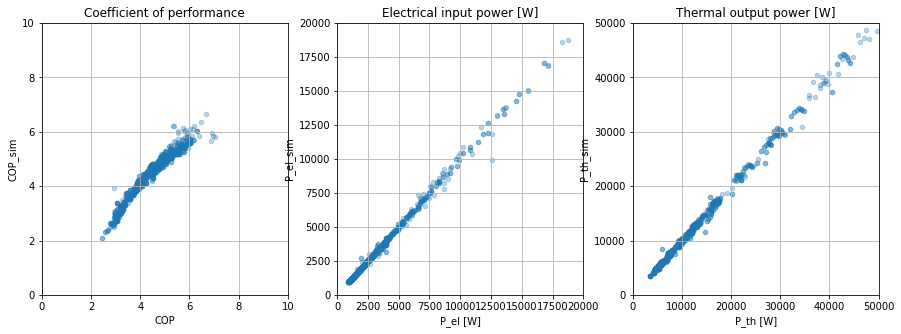

In [21]:
# Plot absolute values all heat pumps of type brine/water | on-off as scatter plot
Group = 5
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.3 Water/Water | on/off** <a class="anchor" id="water-water-onoff" name="water-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 1.6 % for COP
    * 1.6 % for P_el
    * 2.4 % for P_th
* **Important**: Validation data is only available at primary input temperature of 10 °C.

RE_COP     1.833587
RE_P_el    1.645394
RE_P_th    2.304185
dtype: float64

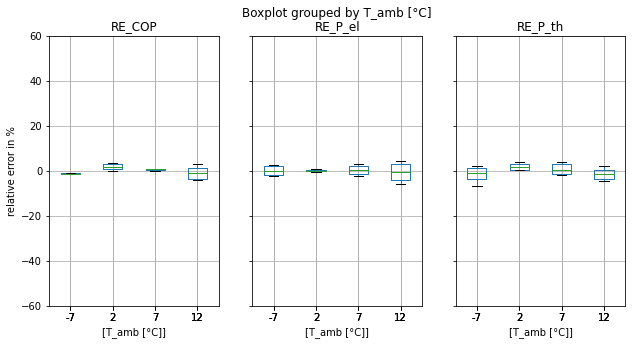

In [22]:
# Plot relative error for all heat pumps of type water/water | on-off
Group = 6
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

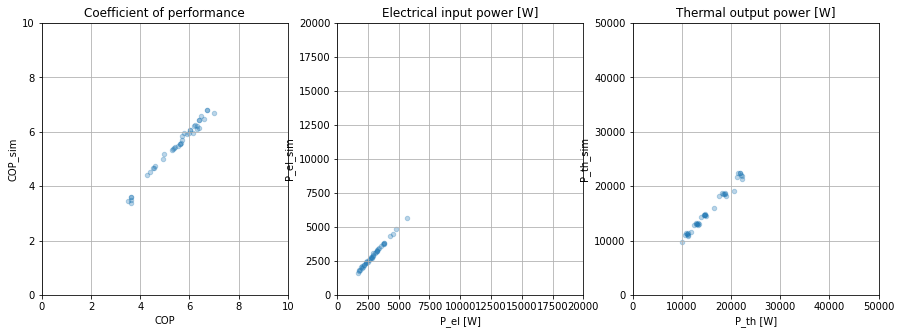

In [23]:
# Plot absolute values all heat pumps of type water/water | on-off as scatter plot
Group = 6
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.4 Air/Water | regulated** <a class="anchor" id="air-water-regulated" name="air-water-regulated"></a>

**Heating**
* The mean absolute percentage error (MAPE) over all heat pumps is
    * 12.1 % for COP
    * 19.5 % for P_el
    * 23.5 % for P_th

**Cooling**
* The mean absolute percentage error (MAPE) over all heat pumps is
    * 4.8 % for EER
    * 16.5 % for P_el
    * 17.0 % for P_th
    
Because of different control strategies, the deviation over different heat pump models is much higher compared to on/off types.

#### **6.4.1 Heating** <a class="anchor" id="air-water-regulated-heating" name="air-water-regulated-heating"></a>

RE_COP     11.917326
RE_P_el    18.527352
RE_P_th    22.933555
dtype: float64

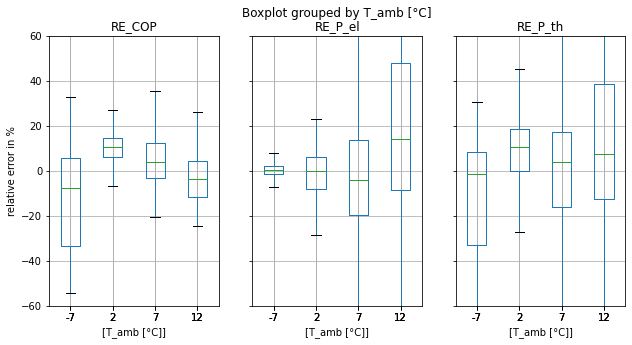

In [34]:
# Plot relative error for all heat pumps of type air/water | regulated
Group = 1
data = df.loc[(df['Group']==Group)&(df['T_amb [°C]']<20)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

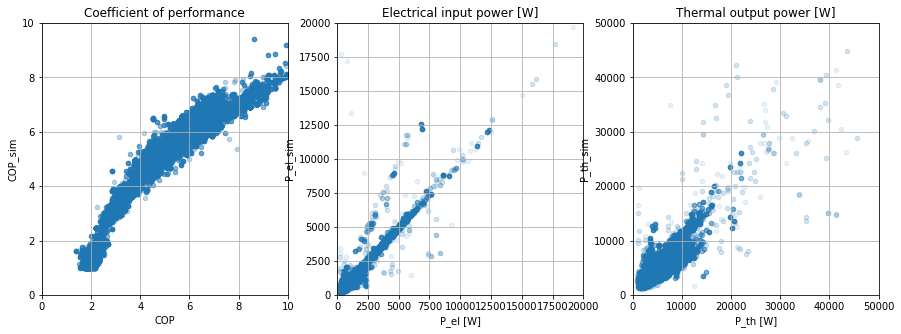

In [35]:
# Plot absolute values all heat pumps of type air/water | regulated as scatter plot
Group = 1
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

#### **6.4.2 Cooling** <a class="anchor" id="air-water-regulated-cooling" name="air-water-regulated-cooling"></a>

RE_Pdc     16.871960
RE_P_el    16.358412
RE_EER      5.543066
dtype: float64

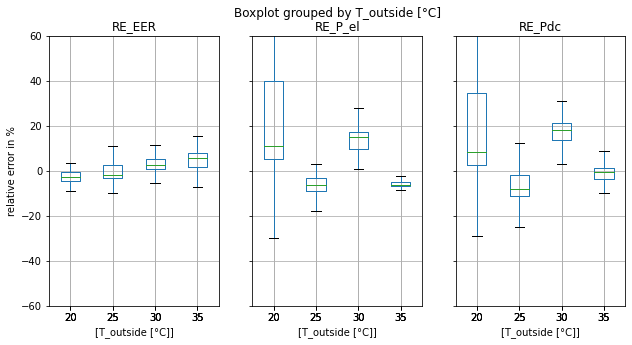

In [26]:
data = pd.read_csv('../output/database_cooling_reduced_normalized_validation.csv')
data = data[['T_outside [°C]','RE_Pdc', 'RE_P_el', 'RE_EER']]
ax = data.boxplot(by='T_outside [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 15000.0)

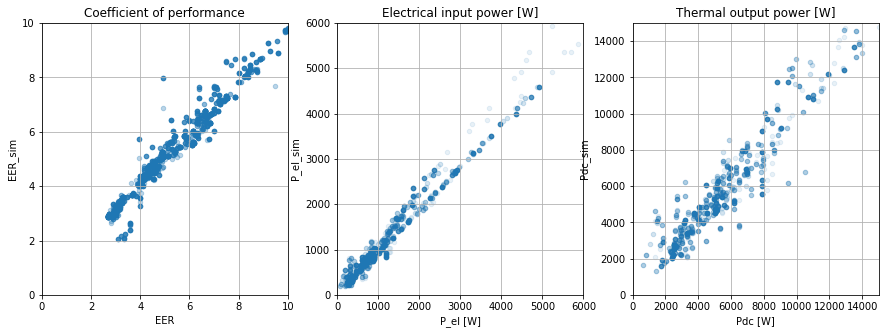

In [27]:
data = pd.read_csv('../output/database_cooling_reduced_normalized_validation.csv')
fig, ax = plt.subplots(1,3)
data.plot.scatter(ax=ax[0], x='EER',y='EER_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='Pdc [W]',y='Pdc_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,6000)
ax[1].set_ylim(0,6000)
ax[2].set_xlim(0,15000)
ax[2].set_ylim(0,15000)

### **6.5 Brine/Water | regulated** <a class="anchor" id="brine-water-regulated" name="brine-water-regulated"></a>

* The mean absolute percentage error (MAPE) is over all heat pumps is
    * 4.2 % for COP
    * 17.7 % for P_el
    * 19.7 % for P_th
* **Important**: Validation data is only available at primary input temperature of 0 °C.  

RE_COP      4.706628
RE_P_el    15.119179
RE_P_th    18.065778
dtype: float64

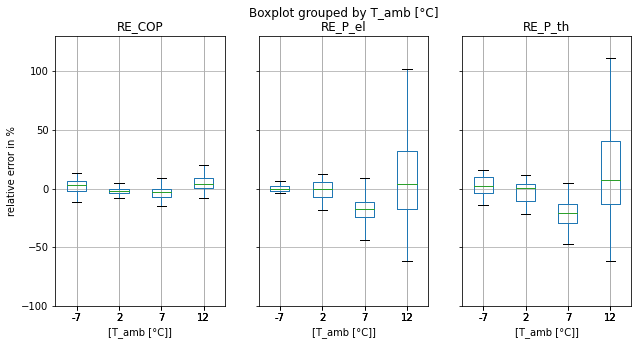

In [28]:
# Plot relative error for all heat pumps of type brine/water | regulated
Group = 2
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-100,130)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

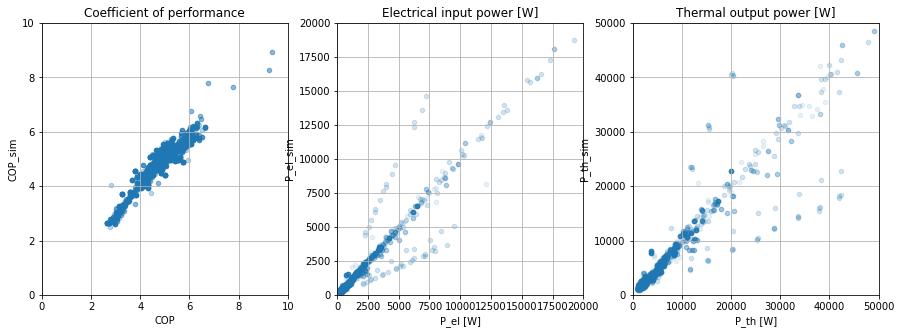

In [29]:
# Plot absolute values all heat pumps of type brine/water | regulated as scatter plot
Group = 2
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

## **7. Conclusion** <a class="anchor" id="conclusion" name="conclusion"></a>

- On/Off heat pumps can be simulated very well (mean relative error < 6 %)
- Regulated heat pumps show a good values in terms of COP and EER but relative mean errors about 15-20 % for electrical and thermal power, because of the non-linearity regarding different primary / secondary temperatures.
- Despite of that, generic heat pumps should work well, because the median shows only a small relative error

## **8. Additional functions** <a class="anchor" id="additional-functions" name="additional-functions"></a>

The hplib has an additonal class with functions regarding the heating system. For example it is possible to calculate the brine temperatur or the calculate the temperature of the heating distribution system.

In [30]:
# Initialize a heating system
t_hs_set = [35,28]  # example for floor heating
f_hs_exp = 1.1      # example for floor heating
t_min = -11         # example minimum reference outside temperature for building

HS = hpl.HeatingSystem(t_outside_min=-11,t_hs_set=t_hs_set,f_hs_exp=f_hs_exp)

In [31]:
# Calculate heating flow and return temperature
t_avg_d = -3        # average temperatur of day

t_dist = HS.calc_heating_dist_temp(t_avg_d=t_avg_d)
print('Heating flow temperatur = '+str(round(t_dist[0],1)))
print('Heating return temperatur = '+str(round(t_dist[1],1)))

Heating flow temperatur = 31.4
Heating return temperatur = 26.1


In [32]:
# Calculate brine temperature as function of outside temperature
# for heat pumps with earth probes
t_avg_d = -3

t_brine = HS.calc_brine_temp(t_avg_d = t_avg_d)
print('Brine flow temperatur = '+str(round(t_brine,1)))


Brine flow temperatur = 4.2
